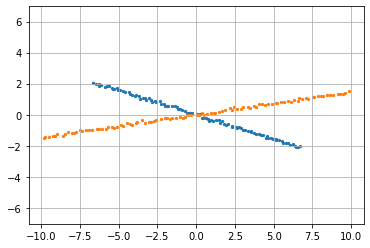

In [199]:
#
# Principal component analysis
#

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw


D = 100
N = 100
x = np.linspace(0, 1, num=D)
scale = np.linspace(-1, 1, num=N).reshape([-1, 1]) # 1-dimentional parameter by scaling
noise = 0.05 * np.random.normal(size=[N, D])
ys = noise + scale * np.sin(2 * np.pi * x) # sin waves 
zs = noise + scale * np.sign(np.sin(2 * np.pi * x)) # square waves

# 200 samples
# 100 dimentional data
A = np.concatenate([ys, zs])

# PCA
B = (A.T @ A) / A.shape[0]
egvals, egvecs = np.linalg.eigh(B)
egvals = np.flip(egvals)
egvecs = np.flip(egvecs, 1)

# Project to principal axes
projection = A @ egvecs

def show_sample(n=0):
    fig, ax = plt.subplots()
    ax.set(ylim=[-1.1, 1.1])
    ax.plot(x, A[n])
    ax.grid()    

def show_egvec(k=0):
    fig, ax = plt.subplots()
    ax.plot(x, egvecs[:, k])
    ax.grid()    

def show_pca(k=[0, 1]):
    fig, ax = plt.subplots()
    p1 = projection[:, k[0]]
    p2 = projection[:, k[1]]
    ax.axis('equal')
    ax.scatter(p1[:N], p2[:N], s=5, c='C0')
    ax.scatter(p1[N:], p2[N:], s=5, c='C1')
    ax.grid()

# ipyw.interact(show_sample, n=(0, A.shape[0] - 1, 1))
# ipyw.interact(show_egvec, k=(0, egvecs.shape[1] - 1, 1))
show_pca(k=[0, 1])

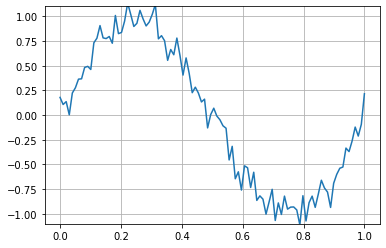

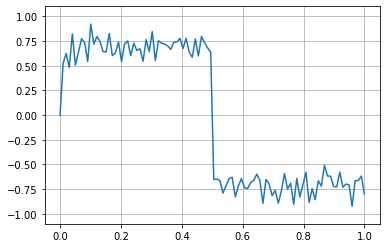

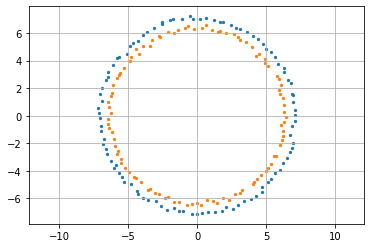

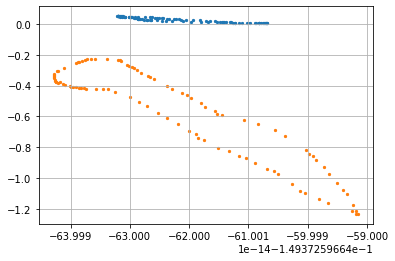

In [86]:
#
# Laplacian eigenmap
#

import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import ipywidgets as ipyw

D = 100
N = 100
x = np.linspace(0, 1, num=D)
translation = np.linspace(0, 1, num=N).reshape([-1, 1]) # 1-dimentional parameter by translation
ys = np.sin(2 * np.pi * (x - translation)) # sin waves
zs = np.sign(ys) # square waves
zs *= np.linalg.norm(ys[0]) / np.linalg.norm(zs[0]) # rescale to have same l2 norm

# 200 samples
# 100 dimentional data
A = np.concatenate([ys, zs])
np.random.seed(3)
A += 0.1 * np.random.normal(size=A.shape)

# PCA
B = (A.T @ A) / A.shape[0]
egvals, egvecs = np.linalg.eigh(B)
egvecs = np.flip(egvecs, 1)
projection = A @ egvecs # Project to principal axes

# Laplacian eigenmap (aka. Dirichlet energy minization with "diag-weight" constraint)
param = 1.0
dist2 = np.sum((np.expand_dims(A, 1) - A) ** 2, 2)
weight = np.exp(-dist2 / param)
lap_off_diag = weight - np.diag(np.diag(weight))
lap_diag = np.diag(np.sum(lap_off_diag, 0))
lap = lap_diag - lap_off_diag # Laplacian (positive semi-definite)
lap_egvals, lap_egvecs = scipy.linalg.eigh(lap, lap_diag)

# L2 Neighbors
neighbors = np.argsort(dist2, 1)

def show_sample(n=0):
    fig, ax = plt.subplots()
    ax.set(ylim=[-1.1, 1.1])
    ax.plot(x, A[n])
    ax.grid()

def show_egvec(n=0):
    fig, ax = plt.subplots()
    ax.plot(x, egvecs[:, n])
    ax.grid()
    
def show_neighbor(n=0, k=1):
    fig, ax = plt.subplots()
    ax.plot(x, A[neighbors[n, k]])
    ax.grid()    

# TODO: draw in 3d with 3rd axis
def show_pca(k=[0, 1]):
    fig, ax = plt.subplots()
    p1 = projection[:, k[0]]
    p2 = projection[:, k[1]]
    ax.axis('equal')
    ax.scatter(p1[:N], p2[:N], s=5, c='C0')
    ax.scatter(p1[N:], p2[N:], s=5, c='C1')
    ax.grid()

def show_lap(k=[0, 1]):
    fig, ax = plt.subplots()
    p1 = lap_egvecs[:, k[0]]
    p2 = lap_egvecs[:, k[1]] 
    ax.scatter(p1[:N], p2[:N], s=5, c='C0')
    ax.scatter(p1[N:], p2[N:], s=5, c='C1')
    ax.grid()    

# Simple viewer (sample, eigen vector, neighbor)
# ipyw.interact(show_sample, n=(0, A.shape[0] - 1, 1))  
# ipyw.interact(show_egvec, n=(0, egvecs.shape[1] - 1, 1))  
# ipyw.interact(show_neighbor, n=(0, A.shape[0] - 1, 1), k=(0, A.shape[0] - 1, 1))

show_sample(n=0)
show_sample(n=N)
show_pca(k=[0, 1])
show_lap(k=[0, 1])

In [3]:
#
# Numba utils
#
import numba


# Cf. Chris Wellons https://nullprogram.com/blog/2018/07/31/
@numba.njit(["uint32(uint32)"])
def hash_uint32(x):
    x ^= x >> 16
    x *= 0x7feb352d
    x ^= x >> 15
    x *= 0x846ca68b
    x ^= x >> 16
    return x


@numba.njit(["uint32(uint32, uint32)"])
def hash21_uint32(x1, x2):
    return hash_uint32(hash_uint32(x1) ^ x2)


@numba.njit(["uint32(uint32, uint32, uint32)"])
def hash31_uint32(x1, x2, x3):
    return hash_uint32(hash_uint32(hash_uint32(x1) ^ x2) ^ x3)


@numba.njit(["float32(uint32)"])
def uint32_to_float32(x):
    return (x >> 9) / (1 << 23)

In [4]:
#
# Nearest Neighbor Descent
# TODO: use binary heap for faster larger neighbor count
#
import numpy as np


@numba.njit(["float32(uint32, uint32, float32[:, :])"])
def nnd_dfunc(i, j, data):
    v = data[i] - data[j]
    return np.dot(v, v)


@numba.njit(["void(uint32[:, :], float32[:, :])"], parallel=True) # idx, dist: inout
def nnd_init_sort(idx, dist):
    [n, k] = idx.shape
    for i in numba.prange(n): # TODO: I thought it should give num-threads-times speed up trivially, but it seems two-times slower.
        # Insertion sort "dist[i]"
        for p in range(1, k):
            while 0 < p:
                if dist[i, p - 1] < dist[i, p]:
                    break
                [dist[i, p], dist[i, p - 1]] = [dist[i, p - 1], dist[i, p]]
                [idx[i, p], idx[i, p - 1]] = [idx[i, p - 1], idx[i, p]]
                p -= 1


@numba.njit(["void(float32[:, :], uint32[:, :], float32[:, :])"]) # dist: out
def nnd_init_dist(data, idx, dist):
    [n, k] = idx.shape
    for i in range(n):
        for j in range(k):
            dist[i, j] = nnd_dfunc(i, idx[i, j], data)


# Initialize random neighbors by cheap hash
@numba.njit(["void(uint32, uint32, uint32[:, :])"]) # idx: out
def nnd_init_idx(n, k, idx):
    # Fisher-Yates choice(n - 1, k) for each row
    m = n - 1
    ls = np.arange(m, dtype=np.uint32) # We can reuse {0,..,m-1} without bias
    for i in range(n):
        # Fisher-Yates choice(m, k) with cheap hash
        for j1 in range(k):
            j2 = j1 + (hash21_uint32(i, j1) % (m - j1))
            [ls[j1], ls[j2]] = [ls[j2], ls[j1]]
        idx[i] = ls[:k]
        
    # Remap {0, .., n - 2} -> {0, .., i-1, i+1, .., n - 1}
    for i in range(n):
        for p in range(k):
            if i <= idx[i, p]:
                idx[i, p] += 1


@numba.njit(["uint32(uint32, uint32, float32[:, :], uint32[:, :], float32[:, :])"])
def nnd_update(i, j, data, idx, dist):
    k = idx.shape[1]
    d = nnd_dfunc(i, j, data)

    # Compare with tail
    if dist[i, k - 1] <= d:
        return 0

    # Check if "j" is in "idx[i]"
    for p in range(k):
        if idx[i, p] == j:
            return 0

    # Insert from tail
    p = k - 1
    idx[i, p] = j
    dist[i, p] = d
    while 0 < p:
        if dist[i, p - 1] < dist[i, p]:
            break
        [dist[i, p], dist[i, p - 1]] = [dist[i, p - 1], dist[i, p]]
        [idx[i, p], idx[i, p - 1]] = [idx[i, p - 1], idx[i, p]]        
        p -= 1
    return 1


@numba.njit(["uint32(uint32, uint32, float32[:, :], uint32[:, :], float32[:, :], uint32[:, :], float32[:, :])"])
def nnd_step(n, k, data, idx, dist, idx_tmp, dist_tmp):
    c = 0
    for i in range(n):
        for pj1 in range(k):
            for pj2 in range(k):
                j1 = idx[i][pj1]
                j2 = idx[j1][pj2]
                if i == j2:
                    continue
                c += nnd_update(i, j2, data, idx_tmp, dist_tmp)
    idx[:] = idx_tmp
    dist[:] = dist_tmp
    return c

In [5]:
# Cf. https://github.com/visionmedia/debug
class Debug:
    def __init__(self):
        self.time = None
        self.delta_time = None
        
    def __call__(self, message):
        import sys, time
        if self.time is None:
            self.time = time.time()
        prev = self.time
        self.time = time.time()
        self.delta_time = self.time - prev
        print(f"{message} [+{self.delta_time * 1000:.0f}ms]", flush=True, file=sys.stdout)


def nnd(data, k, delta=0.001, debug=False):
    if debug: ddd = Debug()

    n = data.shape[0]
    idx = np.empty([n, k], np.uint32)
    dist = np.empty([n, k], np.float32)

    if debug: ddd('nnd_init_idx')
    nnd_init_idx(n, k, idx)

    if debug: ddd('nnd_init_dist')
    nnd_init_dist(data, idx, dist)

    if debug: ddd('nnd_init_sort')
    nnd_init_sort(idx, dist)

    c_lim = delta * n * k
    idx_tmp = np.copy(idx)
    dist_tmp = np.copy(dist)

    if debug: ddd('nnd_loop')

    while True:
        c = nnd_step(n, k, data, idx, dist, idx_tmp, dist_tmp)
        if debug: ddd(f"nnd_step (c = {c})")
        if c <= c_lim:
            break
    return idx, dist

In [6]:
import scipy.sparse
import scipy.sparse.linalg

def sparse_op(np_op, arg):
    result = arg.copy()
    result.data = np_op(arg.data)
    return result

def csr_from_knn(indices, data):
    [n, k] = indices.shape
    indptr = np.arange(n + 1) * k
    indices = indices.reshape([-1])
    data = data.reshape([-1])
    csr = scipy.sparse.csr_matrix((data, indices, indptr), shape=[n, n])
    return csr

def laplacian_eigenmap(dist2):
    lap_off_diag = sparse_op(np.exp, -dist2)
    lap_diag_vec = np.ravel(lap_off_diag.sum(axis=1))
    lap_diag_vec_sqrt_inv = np.sqrt(1 / lap_diag_vec)
    lap_diag = scipy.sparse.diags(lap_diag_vec)
    lap_diag_sqrt_inv = scipy.sparse.diags(lap_diag_vec_sqrt_inv)
    lap = lap_diag - lap_off_diag
    A = lap_diag_sqrt_inv * lap * lap_diag_sqrt_inv

    # TODO: It doesn't seem deterministic even if setting "v0=ones"
    # TODO: Study ARPACK implementation
    # egvals, egvecs = scipy.sparse.linalg.eigsh(A, which='SM', k=4, v0=np.ones(A.shape[0])) 
    egvals, egvecs = scipy.sparse.linalg.eigsh(A, sigma=0, which='LM', k=4, v0=np.ones(A.shape[0])) 

    egvecs = lap_diag_vec_sqrt_inv.reshape([-1, 1]) * egvecs
    return egvals, egvecs

In [7]:
data = np.arange(2**15, dtype=np.float32).reshape((-1, 1))
nnd(data, 20, debug=True)

nnd_init_idx [+0ms]
nnd_init_dist [+118ms]
nnd_init_sort [+110ms]
nnd_loop [+1767ms]
nnd_step (c = 1817381) [+6453ms]
nnd_step (c = 1656582) [+5892ms]
nnd_step (c = 881551) [+4438ms]
nnd_step (c = 23820) [+2412ms]
nnd_step (c = 6) [+2504ms]


(array([[    1,     2,     3, ...,    18,    19,    20],
        [    2,     0,     3, ...,    18,    19,    20],
        [    1,     3,     0, ...,    18,    19,    20],
        ...,
        [32766, 32764, 32763, ..., 32749, 32748, 32747],
        [32765, 32767, 32764, ..., 32749, 32748, 32747],
        [32766, 32765, 32764, ..., 32749, 32748, 32747]], dtype=uint32),
 array([[  1.,   4.,   9., ..., 324., 361., 400.],
        [  1.,   1.,   4., ..., 289., 324., 361.],
        [  1.,   1.,   4., ..., 256., 289., 324.],
        ...,
        [  1.,   1.,   4., ..., 256., 289., 324.],
        [  1.,   1.,   4., ..., 289., 324., 361.],
        [  1.,   4.,   9., ..., 324., 361., 400.]], dtype=float32))

In [4]:
#
# MNIST dataset http://yann.lecun.com/exdb/mnist/
#
!mkdir -p ../data/mnist
!wget -c -O ../data/mnist/t10k-images-idx3-ubyte.gz http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget -c -O ../data/mnist/t10k-labels-idx1-ubyte.gz http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gzip -c -d ../data/mnist/t10k-images-idx3-ubyte.gz > ../data/mnist/t10k-images-idx3-ubyte
!gzip -c -d ../data/mnist/t10k-labels-idx1-ubyte.gz > ../data/mnist/t10k-labels-idx1-ubyte

--2020-07-07 16:08:26--  http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.6.204, 104.28.7.204, 172.67.171.76, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.6.204|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-07-07 16:08:27--  http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.28.7.204, 104.28.6.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [8]:
import numpy as np

x = np.fromfile('../data/mnist/t10k-images-idx3-ubyte', np.uint8, offset=16)
y = np.fromfile('../data/mnist/t10k-labels-idx1-ubyte', np.uint8, offset=8)

x = x.reshape((-1, 28 * 28))
x = x.astype(np.float32) / 255

assert x.shape == (10000, 28 * 28)
assert y.shape == (10000,) 

In [9]:
neighbor_idx, neighbor_dist = nnd(x, 20, debug=True)

nnd_init_idx [+0ms]
nnd_init_dist [+30ms]
nnd_init_sort [+215ms]
nnd_loop [+530ms]
nnd_step (c = 573898) [+5645ms]
nnd_step (c = 388384) [+5296ms]
nnd_step (c = 158810) [+4549ms]
nnd_step (c = 21184) [+3912ms]
nnd_step (c = 3455) [+3758ms]
nnd_step (c = 909) [+3773ms]
nnd_step (c = 280) [+3759ms]
nnd_step (c = 115) [+3773ms]


In [10]:
# TODO: this is so arbitrary. (try t-SNE style weight symmetrization)
def scale_local_distance(dist):
    dist -= np.min(dist, axis=1, keepdims=True)
    dist /= np.max(dist, axis=1, keepdims=True)
    dist *= 2

neighbor_local_dist = np.copy(neighbor_dist)
scale_local_distance(neighbor_local_dist)

In [11]:
# [ Simple normalization ]
# param = 0.05 * 28 * 28
# dist_csr = csr_from_knn(neighbor_idx, neighbor_dist / param)

# [ Local normalization ]
dist_csr = csr_from_knn(neighbor_idx, neighbor_local_dist)

egvals, egvecs = laplacian_eigenmap(dist_csr)
egvals # TODO: it seems dim(Ker(Laplacian)) = 2

array([-6.9714012e-09,  5.8966383e-09,  1.1729841e-03,  3.1486421e-03],
      dtype=float32)

In [268]:
#
# Edge probability cross entropy minimization by Monte-Carlo
# 
#   loss = \sum_{v0, v1} H[P(v0, v1) || P'(v0, v1)] 
#        = \sum P (-logP') + (1 - P) (-log(1-P'))
#        = \sum P (-logP' + log(1-P')) + \sum - log(1-P')
#   Dloss = \sum P (-1/P' - 1/1-P') DP' + \sum (1/1-P') DP'
#
#   where
#     P  : target edge probability obtained from neighbor-distance graph
#     P' : edge probability obtained from low-dim vertex position
#     D  : derivative w.r.t. low dimentional vertex position
#
#   To evaluate "Dloss", we employ
#     \sum (1/1-P') DP'  :  Monte-Carlo by uniform sampling of all vertex pairs
#
#   Here, we (arbitrary) define P' by:
#     P'(v0, v1) = exp(- |v0 - v1|^2)
#
#   And thus, 
#     D_{v0}P' = P' 2 (v1 - v0)
#     (-1/P' - 1/1-P') DP' = - 2/(1-P') (v1 - v0)
#     (1/1-P') DP' = 2 (P'/1-P') (v1 - v0)
#
# NOTE:
#  - Since neighbor only counts "k", the number of (v0, v1) s.t. P(v0, v1) > 0 is under estimated,
#    So, we need to balance out by tweaking "hp1".
#  - Compare with LargeViz
#    - it seems solving same problem but they got a lot of approximation for speed
#    - they try different choice of P'
# 

@numba.njit(["void(uint32[:, :], float32[:, :], float32[:, :], float32, uint32, uint32, float32)"])
def optimize_cross_entropy(neighbor_idx, neighbor_prob, verts, rate, num_repel_samples, epoch, hp1):
    [n, k] = neighbor_idx.shape
    dv = np.zeros_like(verts)
    for i in range(n):
        v0 = verts[i]
        for kk in range(k):
            p = neighbor_prob[i][kk]
            j = neighbor_idx[i][kk]
            v1 = verts[j]

            # [ P' = exp(- l^2) ]
            q = np.exp(- np.dot(v0 - v1, v0 - v1))
            dv0 = p * (2 / (1 - q + 1e-6)) * (v1 - v0)
            dv[i] -= dv0

            # [ P' = 1 / (1 + l^2) ]
            # l2 = np.dot(v0 - v1, v0 - v1) + 1e-6
            # dv0 = p * 2 / l2 * (v1 - v0)
            # dv[i] -= dv0


        # Monte Carlo: \sum - (1/1-P') DP = \sum - (P'/1-P') (v1 - v0)
        for jj in range(num_repel_samples):
            j = hash31_uint32(i, jj, epoch) % n
            v1 = verts[j]

            # [ P' = exp(- l^2) ]
            q = np.exp(- np.dot(v0 - v1, v0 - v1))
            dv0 = (2 * q / (1 - q + 1e-6)) * (v1 - v0)
            dv[i] += hp1 * (n / num_repel_samples) * dv0

            # [ P' = 1 / (1 + l^2) ]
            # l2 = np.dot(v0 - v1, v0 - v1) + 1e-6
            # dv0 = 2 / ((1 + l2) * l2) * (v1 - v0)
            # dv[i] += hp1 * (n / num_repel_samples) * dv0

    verts -= rate / n * dv

In [269]:
# [ Simple scaling ]
# param = 0.05 * 28 * 28
# neighbor_prob = np.exp(- neighbor_dist / param)

# [ Local scaling ]
neighbor_prob = np.exp(- neighbor_local_dist)

# Initialize with eigen vectors
verts = np.float32(egvecs[:, [2, 3]])

# TODO: Initialize with random (this clearly doesn't make cluster)
# verts = 2 * np.random.random((x.shape[0], 2)).astype(np.float32) - 1

In [270]:
rate = 1
num_repel_samples = 10
epoch = 0
hp1 = 0

In [271]:
num_epochs = 500
for _ in range(num_epochs):
    optimize_cross_entropy(neighbor_idx, neighbor_prob, verts, rate, num_repel_samples, epoch, hp1)
    epoch += 1
    hp1 += 0.000001 # TODO: monkey patch repeling from 0 to 0.0005

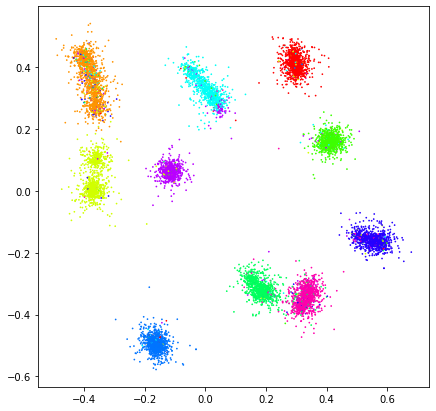

In [272]:
show_embedding()

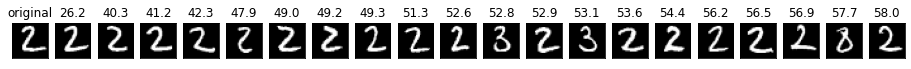

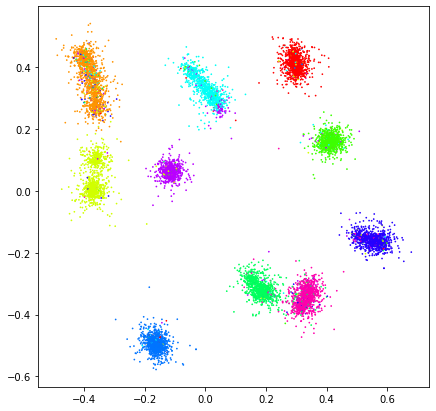

In [140]:
import matplotlib.pyplot as plt
import ipywidgets as ipyw

def show_sample(n=0, ax=False):
    ax = ax or plt.gca()
    ax.imshow(x[n].reshape([28, 28]), cmap='gray')
    
def show_neighbor(n=0, k=1, ax=False):
    dist2 = np.sum((np.expand_dims(x[n], 0) - x) ** 2, -1)
    neighbors = np.argsort(dist2)
    ax = ax or plt.gca()
    ax.imshow(x[neighbors[k]].reshape([28, 28]), cmap='gray')
    
def show_neighbor_nnd(n=0, k=0, ax=False):
    j = neighbor_idx[n, k]
    d = neighbor_dist[n, k]
    ax = ax or plt.gca()
    ax.set(title=f"{d:.3}", xticks=[], yticks=[])
    ax.imshow(x[j].reshape([28, 28]), cmap='gray')

def show_neighbors_nnd(n=0):
    K = neighbor_idx.shape[1]
    fig, axes = plt.subplots(1, K + 1, figsize=(16, 16))
    axes[0].set(title="original", xticks=[], yticks=[])
    show_sample(n, axes[0])
    for k in range(K):
        show_neighbor_nnd(n, k, axes[k + 1])

def show_embedding(y0=True, y1=True, y2=True, y3=True, y4=True, y5=True, y6=True, y7=True, y8=True, y9=True):
    mask = np.zeros_like(y, dtype=np.bool)    
    for i, yi in enumerate([y0, y1, y2, y3, y4, y5, y6, y7, y8, y9]):
        if yi:
            mask += y == i

    f1 = verts[mask, 0]
    f2 = verts[mask, 1]
    g = y[mask] / 10

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(f1, f2, c=g, s=0.5, cmap='hsv', vmin=0, vmax=1)

# Viewer
# ipyw.interact(show_sample, n=(0, x.shape[0] -1))
# ipyw.interact(show_neighbor, n=(0, x.shape[0] -1), k=(0, x.shape[0] -1, 10))
# ipyw.interact(show_neighbor_nnd, n=(0, x.shape[0] -1), k=(0, neighbor_idx.shape[1] - 1))
# ipyw.interact(show_neighbors_nnd, n=(0, x.shape[0] -1))
# ipyw.interact(show_embedding)
show_neighbors_nnd(1)
show_embedding()

In [10]:
#
# fasion MNIST 
#
!mkdir ../data/fashion-mnist
!wget -c -O ../data/fashion-mnist/t10k-images-idx3-ubyte.gz https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz
!wget -c -O ../data/fashion-mnist/t10k-labels-idx1-ubyte.gz https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz
!gzip -c -d ../data/fashion-mnist/t10k-images-idx3-ubyte.gz > ../data/fashion-mnist/t10k-images-idx3-ubyte
!gzip -c -d ../data/fashion-mnist/t10k-labels-idx1-ubyte.gz > ../data/fashion-mnist/t10k-labels-idx1-ubyte        

mkdir: cannot create directory ‘../data/fashion-mnist’: File exists
--2020-07-07 16:08:57--  https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz [following]
--2020-07-07 16:08:59--  https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.88.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.88.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--20

In [11]:
import numpy as np

x = np.fromfile('../data/fashion-mnist/t10k-images-idx3-ubyte', np.uint8, offset=16)
y = np.fromfile('../data/fashion-mnist/t10k-labels-idx1-ubyte', np.uint8, offset=8)

x = x.reshape((-1, 28 * 28))
x = x.astype(np.float32) / 255
assert x.shape == (10000, 28 * 28)
assert y.shape == (10000,) 

In [12]:
neighbor_idx, neighbor_dist = nnd(x, 10, debug=True)

nnd_init_idx [+0ms]
nnd_init_dist [+15ms]
nnd_init_sort [+136ms]
nnd_loop [+56ms]
nnd_step (c = 219973) [+1303ms]
nnd_step (c = 180415) [+1182ms]
nnd_step (c = 134975) [+1160ms]
nnd_step (c = 58746) [+1004ms]
nnd_step (c = 14203) [+1058ms]
nnd_step (c = 3456) [+1167ms]
nnd_step (c = 1158) [+972ms]
nnd_step (c = 453) [+892ms]
nnd_step (c = 205) [+892ms]
nnd_step (c = 85) [+903ms]


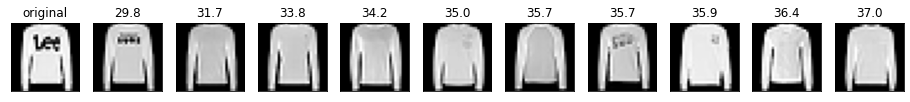

In [13]:
import matplotlib.pyplot as plt
import ipywidgets as ipyw

def show_sample(n=0, ax=False):
    ax = ax or plt.gca()
    ax.imshow(x[n].reshape([28, 28]), cmap='gray')
    
def show_neighbor(n=0, k=1, ax=False):
    dist2 = np.sum((np.expand_dims(x[n], 0) - x) ** 2, -1)
    neighbors = np.argsort(dist2)
    ax = ax or plt.gca()
    ax.imshow(x[neighbors[k]].reshape([28, 28]), cmap='gray')
    
def show_neighbor_nnd(n=0, k=0, ax=False):
    j = neighbor_idx[n, k]
    d = neighbor_dist[n, k]
    ax = ax or plt.gca()
    ax.set(title=f"{d:.3}", xticks=[], yticks=[])
    ax.imshow(x[j].reshape([28, 28]), cmap='gray')

def show_neighbors_nnd(n=0):
    K = neighbor_idx.shape[1]
    fig, axes = plt.subplots(1, K + 1, figsize=(16, 16))
    axes[0].set(title="original", xticks=[], yticks=[])
    show_sample(n, axes[0])
    for k in range(K):
        show_neighbor_nnd(n, k, axes[k + 1])
        
# Viewer
# ipyw.interact(show_sample, n=(0, x.shape[0] -1))
# ipyw.interact(show_neighbor, n=(0, x.shape[0] -1), k=(0, x.shape[0] -1, 10))
# ipyw.interact(show_neighbor_nnd, n=(0, x.shape[0] -1), k=(0, neighbor_idx.shape[1] - 1))
# ipyw.interact(show_neighbors_nnd, n=(0, x.shape[0] -1))
show_neighbors_nnd(1)

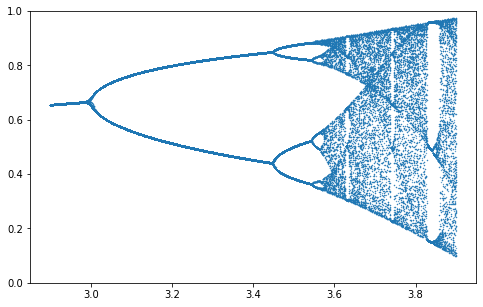

In [187]:
#
# Logistic map
#
# x' = r x (1 - x)
#
# [ Prop. 1 ]
#   x0 : stable fixed point of f <=> f(x0) = x0 and |f'(x0)| < 1
#
# [ Prop. 2 ]
#   Given g(x) = f(f(x)), we have:
#     g'(x) = f'(f(x)) f'(x)
#
#   Thus, for x0 : fixed point of f, we have:
#     g'(x0) = f'(f(x0)) f'(x0) = f'(x0)^2
#
# [ Prop. 3 ]  (plot "_0" helps this observation)
#   Given
#     - g(x | r) = f(f(x | r) | r)
#     - X(r) : stable fixed point of f
#     - f'(X(r0)) = -1
#     - Dr f'(X(r0)) < 0
#   then,
#     - g'(X(r0)) = f'(X(r0))^2 = 1
#     - Dr g'(X(r0)) = 2 f'(X(r0)) Dr(f'(X(r0))) > 1
#   so,
#     at such parameter r0, it changes:
#     - f(x | r0) and g(x | r0) lose stable fixed point X(r0)
#     - g(x | r0) - x have double root at X(r0)
#

import functools
import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def repeat(f, n):
    def rec(x, n):
        if n <= 0:
            return x
        return rec(f(x), n - 1)
    return lambda x: rec(x, n)


# Plot iterated map (f, f^2, ... f^2^k)
def _0(r=3.5, k=2):
    x = np.linspace(0, 1, num=2**8)
    f = lambda x: r * x * (1 - x)
    gs = [repeat(f, 2**i) for i in range(k)]

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set(xlim=[0, 1], ylim=[0, 1])
    ax.grid()
    ax.plot(x, x)
    for g in gs:
        ax.plot(x, g(x))
    

# Visualize evolution for random samples
def _1(r=3.5, m=2**6):
    f = lambda x: r * x * (1 - x)
    num_samples = 16
    num_iters = m

    # [grid samples]
    x = (np.arange(num_samples) + 0.5) / num_samples
    
    # [uniform random samples]
    # x = np.random.default_rng(0).random(num_samples)

    ls_x = [x]
    for i in range(num_iters):
        x = f(x)
        ls_x += [x]
    ls_x = Np(ls_x)

    i = np.arange(num_iters + 1)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set(ylim=[0, 1])

    for x in ls_x.T:
        ax.scatter(i, x, s=15)


# Visualize attractor for different `r` (aka bifurcation diagram)
def _2(r0=0, r1=4):
    
    num_iters = 2**8
    k = 2**10
    n = 2**6
    r = np.linspace(r0, r1, num=k)          # float[k]
    x = (np.arange(num_samples) + 0.5) / n  # float[n]
    
    x = np.repeat(x.reshape((-1, 1)), k, axis=1).reshape(-1)  # float[n * k]
    r = np.repeat(r.reshape((1, -1)), n, axis=0).reshape(-1)  # float[n * k]
    f = lambda x: r * x * (1 - x)
    for i in range(num_iters):
        x = f(x)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set(ylim=[0, 1])
    ax.scatter(r, x, s=0.1)

# _0()
# _1()
_2(r0=2.9, r1=3.9)

# UI
# ipyw.interact(_0, r=(0, 4, 0.01), k=(1, 8, 1))
# ipyw.interact(_1, r=(0, 4, 0.05), m=(1, 2**7, 8))
# ipyw.interact(_2, r0=(0, 4, 0.01), r1=(0, 4, 0.01))

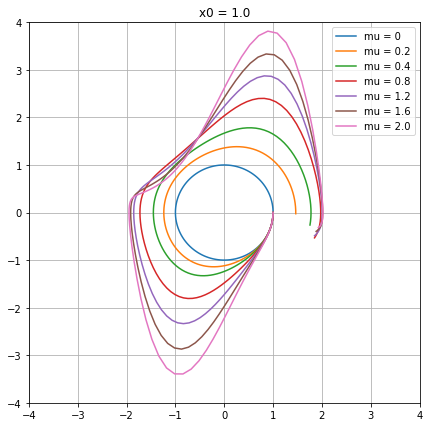

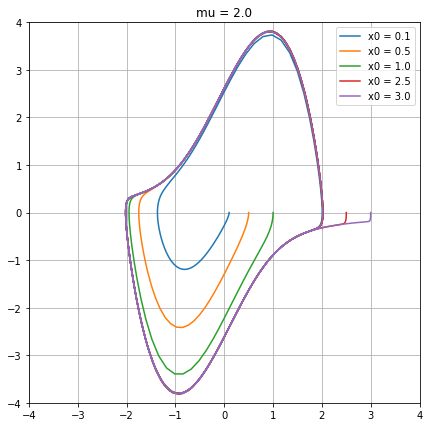

In [60]:
#
# Limit cycle of Van der Pol oscillator 
#
# Dt(x) = v
# Dt(v) = - x - mu (x^2 - 1) v
#

import functools
import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


# Explicit Runge-Kutta 4th order
def erk4(f, t, x, dt):
    k1 = f(t           , x                )
    k2 = f(t + 1/2 * dt, x + 1/2 * dt * k1)
    k3 = f(t + 1/2 * dt, x + 1/2 * dt * k2)
    k4 = f(t + 1   * dt, x + 1   * dt * k3)
    return x + dt * (1/6 * k1 + 2/6 * k2 + 2/6 * k3 + 1/6 * k4)


def solve(f, x, t, dt, N): # -> (float[N+1, ..], float[N+1])
    ls_t = [t]
    ls_x = [x]
    for i in range(N):
        x = erk4(f, t, x, dt)
        t += dt
        ls_t += [t]
        ls_x += [x]
    return Np(ls_x), Np(ls_t)


# Van der Pol equation
def f(t, arg, mu):
    x, v = arg
    dx = v
    dv = - x - mu * (x**2 - 1) * v
    return Np([dx, dv])


# Changing mu
def _0(mu=2.0, ax=False, scatter=True):
    # parameter setup
    x0, v0 = 1, 0
    dt = 0.05
    N = int(2 * np.pi / dt) # so that it fits period for mu = 0

    # system setup
    t0 = 0
    x0 = Np([x0, v0])
    ff = functools.partial(f, mu=mu)
    
    # solve
    ls_x, ls_t = solve(ff, x0, t0, dt, N)

    # plotting
    x, y = ls_x.T
    if ax is False:
        fig, ax = plt.subplots(figsize=(7, 7))
    ax.set(xlim=[-4, 4], ylim=[-4, 4])
    ax.grid()
    if scatter:
        color = np.linspace(0, 1, num=N + 1)  # hsv color gradient by time
        ax.scatter(x, y, c=color, s=8, vmin=0, vmax=1, cmap='hsv', label=f"mu = {mu}")
    else:
        ax.plot(x, y, label=f"mu = {mu}")    
    ax.legend()


def _1(ls_mu):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set(title=f"x0 = 1.0")
    for mu in ls_mu:
        _0(mu, ax, scatter=False)


# Changing initial value x0
def _2(x0=1, ax=False):
    # parameter setup
    mu = 2.0
    dt = 0.05
    N = int(2 * np.pi / dt) * 3

    # system setup
    t0 = 0
    v0 = 0
    ff = functools.partial(f, mu=mu)

    # solve
    ls_x, ls_t = solve(ff, Np([x0, v0]), t0, dt, N)

    x, y = ls_x.T        
    if ax is False:
        fig, ax = plt.subplots(figsize=(7, 7))
    ax.set(xlim=[-4, 4], ylim=[-4, 4])
    ax.grid()
    ax.plot(x, y, label=f"x0 = {x0}")
    ax.legend()


def _3(ls_x0):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set(title=f"mu = 2.0")
    for x0 in ls_x0:
        _2(x0, ax)


# _0(2.0)
_1([0, 0.2, 0.4, 0.8, 1.2, 1.6, 2.0])
# _2(2.5)
_3([0.1, 0.5, 1.0, 2.5, 3.0])

# UI
# ipyw.interact(_0, mu=(0, 8, 0.1))
# ipyw.interact(_2, x0=(0, 10, 0.1))

In [62]:
#
# MNIST
#
import requests
import gzip

requests.get?
gzip.open?

In [1]:
#
# Extract data from pdf
#

import tempfile, subprocess
import requests

    
def get_pdf(url):
    resp = requests.get(url)
    with tempfile.NamedTemporaryFile() as f:
        f.write(resp.content)
        status, result = subprocess.getstatusoutput(f"pdftotext {f.name} -")
        assert status == 0
        return result


url = 'https://www.mhlw.go.jp/content/10900000/000622162.pdf'
result = get_pdf(url)

In [2]:
#
# Extract data from pdf (contd.) : Manual processing
#

import re
import pandas
import numpy as np; Np = np.array

xx = [x.split('\n') for x in result.split('\n\n')]
yy = [x for x in xx if len(x) > 8]
yy[0] = yy[0][2:]
ww = Np(yy).T
pp = ww[:, 0]
qq = np.vectorize(lambda s: np.int(re.sub('[^\d]', '', s)))(ww[:, 1::2])
df = pandas.DataFrame([pp, *qq.T]).T
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,全 国,3191,3569,3817,4168,4667,5246,5902,6616,7123,7509,7964
1,北海道,193,194,194,198,208,226,239,255,267,272,279
2,青森,11,11,11,11,12,14,14,22,22,22,22
3,岩手,0,0,0,0,0,0,0,0,0,0,0
4,宮城,20,23,26,27,34,36,37,46,52,54,64
5,秋田,10,11,11,11,11,11,12,13,15,15,16
6,山形,6,10,13,19,22,27,27,32,34,35,39
7,福島,14,16,16,24,29,33,36,37,38,38,39
8,茨城,59,64,71,77,77,81,82,91,109,110,116
9,栃木,14,14,14,15,21,31,31,32,35,36,38


Category:  全 国


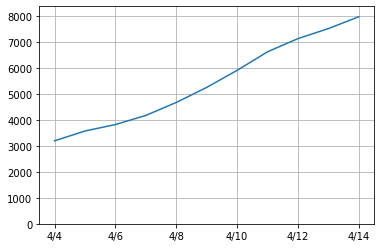

In [3]:
#
# Extract data from pdf (contd.) : Plotting
#

import matplotlib.pyplot as plt
import ipywidgets as ipyw

def _(i=0):
    print("Category: ", pp[i])
    x = np.arange(qq.shape[1])
    y = qq[i, :]

    fig, ax = plt.subplots()
    ax.set(ylim=[0, np.max(y) * 1.05], xticks=x[::2], xticklabels=[f"4/{4 + i}" for i in x][::2])
    ax.grid()
    ax.plot(x, y)

_(0)
# ipyw.interact(_, i=(0, qq.shape[0] - 1, 1))